In [1]:
import spectral
import numpy as np
import os
import random

import spectral
import keras
import glob

In [2]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten


class HSIImageDataGenerator(Sequence):
    def __init__(self, directory, batch_size=5, target_size=(100, 100), shuffle=True, rescale=1.0):
        self.directory = directory
        self.batch_size = batch_size
        self.target_size = target_size
        self.shuffle = shuffle
        self.rescale = rescale
        self.class_indices = {'hyper_L': 0, 'hyper_N': 1, 'hyper_P': 2}
        self._prepare_file_list()

    def _prepare_file_list(self):
        self.file_list = []
        for subdir, class_idx in self.class_indices.items():
            subdir_path = os.path.join(self.directory, subdir)
            files = [f for f in os.listdir(subdir_path) if f.endswith('.raw')]
            for f in files:
                self.file_list.append((os.path.join(subdir_path, f), class_idx))

        if self.shuffle:
            np.random.shuffle(self.file_list)

    def _parse_hdr(self, hdr_file_path):
        dimensions = {}

        with open(hdr_file_path, 'r') as hdr_file:
            for line in hdr_file:
                line = line.strip()
                if line.startswith('samples'):
                    dimensions['width'] = int(line.split('=')[-1].strip())
                elif line.startswith('lines'):
                    dimensions['height'] = int(line.split('=')[-1].strip())
                elif line.startswith('bands'):
                    dimensions['channels'] = int(line.split('=')[-1].strip())
                elif line.startswith('data type'):
                    dimensions['data_type'] = int(line.split('=')[-1].strip())

        return dimensions

    def __len__(self):
        return int(np.ceil(len(self.file_list) / float(self.batch_size)))

    
    def __getitem__(self, idx):
        batch_files = self.file_list[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x, batch_y = [], []

        for file_path, class_idx in batch_files:
            hdr_file_path = file_path.replace('.raw', '.hdr')
            dimensions = self._parse_hdr(hdr_file_path)
            data = np.fromfile(file_path, dtype=np.dtype(f'float{dimensions["data_type"] * 8}'))
            data = data.reshape(dimensions['height'], dimensions['width'], dimensions['channels'])
            data_resized = np.zeros((self.target_size[0], self.target_size[1], dimensions['channels']))
            for i in range(dimensions['channels']):
                data_channel = data[:, :, i].astype(np.float32)
                data_resized[:, :, i] = cv2.resize(data_channel, self.target_size)

            data_resized *= self.rescale
            batch_x.append(data_resized)
            batch_y.append(class_idx)

        batch_x = np.stack(batch_x)
        batch_y = np.array(batch_y)

        return batch_x, batch_y

  
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.file_list)


In [3]:

train_gen = HSIImageDataGenerator(directory='hsi_samples', batch_size=3, target_size =(220,220),  rescale = 1/255.0)

val_gen = HSIImageDataGenerator(directory='hsi_samples_val', batch_size=3, target_size =(220,220),  rescale = 1/255.0)


In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense , Dropout, BatchNormalization, Conv3D, MaxPooling3D, GlobalMaxPooling3D
input_shape = train_gen[0][0][0].shape 


In [5]:

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        print("GPU:", gpu)
else:
    print("No GPUs found")

GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [6]:
model = Sequential([
    Conv3D(8, kernel_size=(2,2,30), activation='relu', input_shape=(220,220, 60, 1)),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(16, kernel_size=(3,3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling3D(pool_size=(2, 2, 2)),
    Conv3D(32, kernel_size=(3,3,3), activation='relu'),
    BatchNormalization(),
    Flatten(),
    Dense(32, activation='relu'),
    Dropout(0.15),
    Dense(3, activation='softmax')  # Assuming 3 classes
])


In [8]:
# Compile the model with binary crossentropy loss and Adam optimizer
from tensorflow.keras.optimizers import Adam
optimizer =Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 219, 219, 31, 8)   968       
                                                                 
 batch_normalization (BatchN  (None, 219, 219, 31, 8)  32        
 ormalization)                                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 109, 109, 15, 8)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 107, 107, 13, 16)  3472      
                                                                 
 batch_normalization_1 (Batc  (None, 107, 107, 13, 16)  64       
 hNormalization)                                                 
                                                        

In [9]:
# Train the model with the train generator
history = model.fit(train_gen ,validation_data=val_gen ,epochs=8,verbose = 1)

Epoch 1/8
26/26 [==============================] - 73s 3s/step - loss: 5.3181 - accuracy: 0.3421 - val_loss: 1.5990 - val_accuracy: 0.3750
Epoch 2/8
26/26 [==============================] - 70s 3s/step - loss: 4.9261 - accuracy: 0.4737 - val_loss: 1.9146 - val_accuracy: 0.3125
Epoch 3/8
26/26 [==============================] - 50s 2s/step - loss: 1.6166 - accuracy: 0.4079 - val_loss: 1.3573 - val_accuracy: 0.3125
Epoch 4/8
26/26 [==============================] - 53s 2s/step - loss: 1.1014 - accuracy: 0.5000 - val_loss: 1.3884 - val_accuracy: 0.3125
Epoch 5/8
26/26 [==============================] - 58s 2s/step - loss: 1.0748 - accuracy: 0.4737 - val_loss: 1.2384 - val_accuracy: 0.3125
Epoch 6/8
26/26 [==============================] - 66s 3s/step - loss: 0.9341 - accuracy: 0.5263 - val_loss: 1.1931 - val_accuracy: 0.3125
Epoch 7/8
26/26 [==============================] - 58s 2s/step - loss: 1.2876 - accuracy: 0.5395 - val_loss: 1.0994 - val_accuracy: 0.3125
Epoch 8/8
26/26 [==========

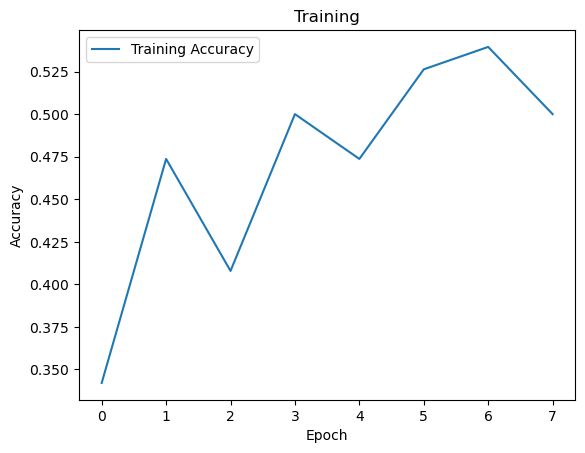

In [12]:
import matplotlib.pyplot as plt

# Get the training and validation accuracy values from the history object
train_acc = history.history['accuracy']


# Plot the training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')

plt.title('Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


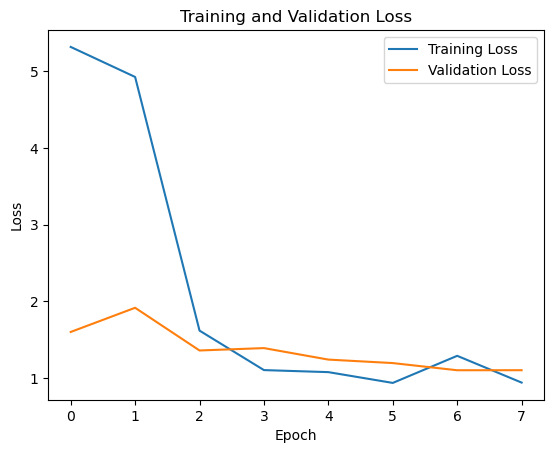

In [11]:
import matplotlib.pyplot as plt

# Get the training and validation loss values from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
